# Hate Speech Model

In [40]:
!rm -rf /kaggle/working/*

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


HARE Training Data Sample:
       Unnamed: 0                                               post  \
12220       15223  if we don't have free speech in america then w...   
11664       20602        this thing needs a bullet between the eyes.   
11367       13935   they aren't pro-white activists  they are  in...   
11521         620  no no no no no no ! ! ! when whites get angry ...   
10773       19773  correct, they're not. so why are they here? ge...   

               class  
12220       not_hate  
11664  implicit_hate  
11367       not_hate  
11521  implicit_hate  
10773  implicit_hate  

CONAN Counter-Speech Data Sample:
      INDEX                                        HATE_SPEECH  \
2380   2380      Muslim immigration is bad for the UK economy.   
4365   4365  I am not a faggot. I am not homophobic. I am n...   
4503   4503  Physically disabled folks are born for being m...   
4776   4776              LGBTI people are a burden on society.   
459     459  We are forced to economi

Processing posts in HARE dataset: 100%|██████████| 12888/12888 [01:21<00:00, 157.56it/s]



Missing values in HARE Dataset:
post     0
class    0
dtype: int64

Missing values in CONAN Dataset:
INDEX                0
HATE_SPEECH          0
COUNTER_NARRATIVE    0
TARGET               0
VERSION              0
hate_length          0
counter_length       0
dtype: int64


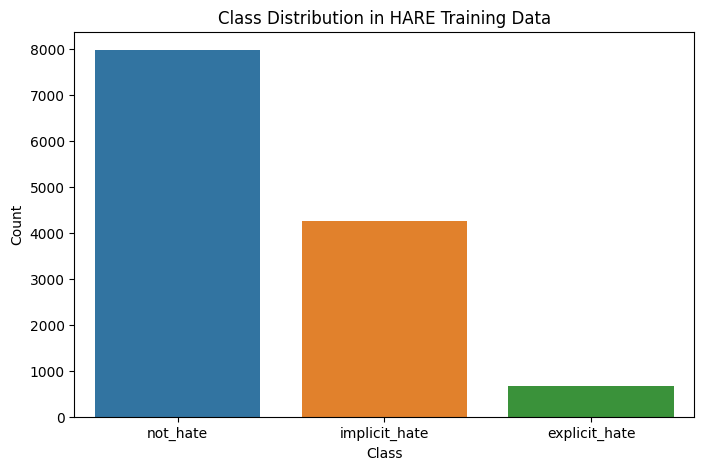

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


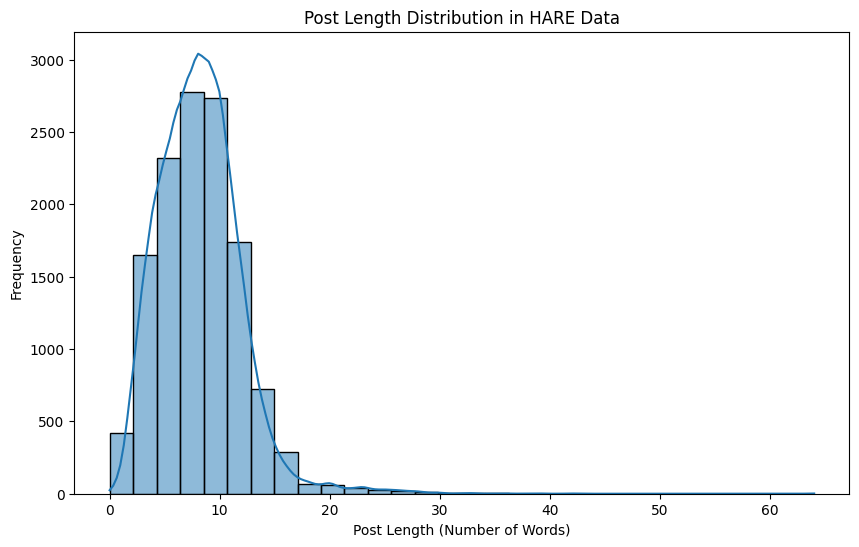

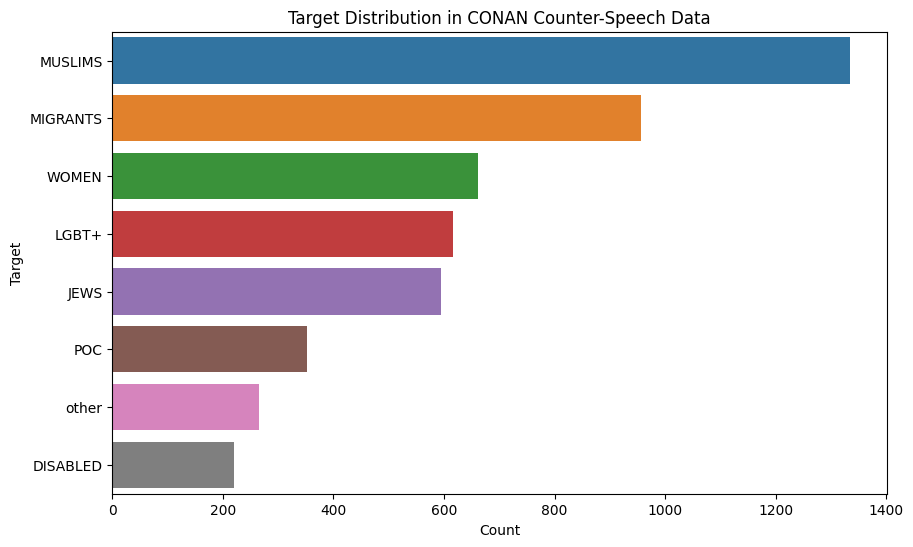

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

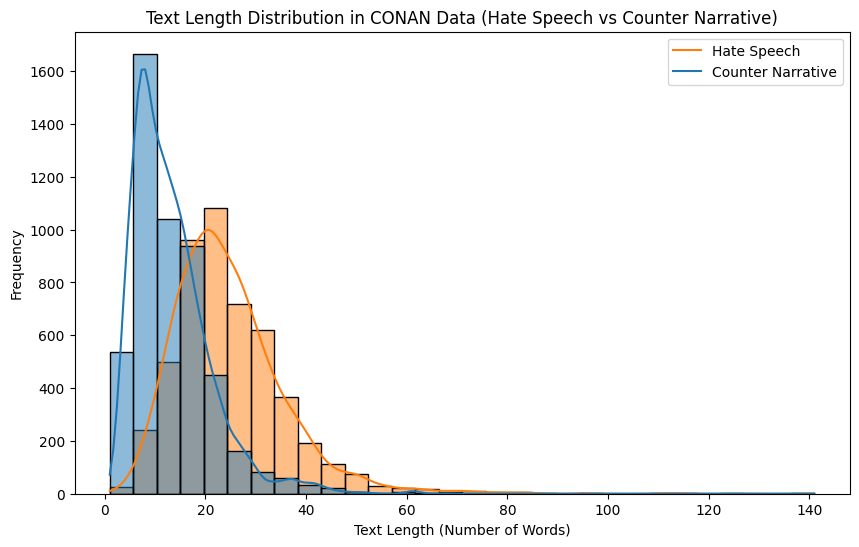


Data preprocessing and EDA completed.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from tqdm import tqdm  # Import tqdm for progress tracking

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Load the datasets
hare_df = pd.read_csv('/kaggle/input/hhhhhh/IH_train.csv')
conan_df = pd.read_csv('/kaggle/input/hhhhhh/Multitarget-CONAN.csv')

# Display initial samples
print("HARE Training Data Sample:")
print(hare_df.sample(5))
print("\nCONAN Counter-Speech Data Sample:")
print(conan_df.sample(5))

# Data Preprocessing for HARE Dataset
def preprocess_hare(df):
    # Drop unnecessary columns if any
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Normalize text: lowercasing and removing special characters
    df['post'] = df['post'].str.lower().apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

    # Tokenization and stopword removal using spaCy
    tqdm.pandas(desc="Processing posts in HARE dataset")
    df['post'] = df['post'].progress_apply(lambda x: ' '.join([token.text for token in nlp(x) if not token.is_stop]))

    return df

# Apply preprocessing with progress tracking
hare_cleaned = preprocess_hare(hare_df)

# Check for missing values
print("\nMissing values in HARE Dataset:")
print(hare_cleaned.isnull().sum())

# Feature Engineering: Add post length
hare_cleaned['post_length'] = hare_cleaned['post'].apply(lambda x: len(x.split()))

# Data Preprocessing for CONAN Dataset
def preprocess_conan(df):
    # Normalize text: lowercasing and removing special characters
    df['HATE_SPEECH'] = df['HATE_SPEECH'].str.lower().apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    df['COUNTER_NARRATIVE'] = df['COUNTER_NARRATIVE'].str.lower().apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

    # Add text length
    df['hate_length'] = df['HATE_SPEECH'].apply(lambda x: len(x.split()))
    df['counter_length'] = df['COUNTER_NARRATIVE'].apply(lambda x: len(x.split()))

    return df

# Apply preprocessing for CONAN dataset
conan_cleaned = preprocess_conan(conan_df)

# Check for missing values
print("\nMissing values in CONAN Dataset:")
print(conan_cleaned.isnull().sum())

# Exploratory Data Analysis

# 1. Class Distribution in HARE Data
plt.figure(figsize=(8, 5))
sns.countplot(data=hare_cleaned, x='class', order=hare_cleaned['class'].value_counts().index)
plt.title('Class Distribution in HARE Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('class_distribution_hare.png')
plt.show()

# 2. Post Length Distribution by Class in HARE Data
plt.figure(figsize=(10, 6))
sns.histplot(hare_cleaned['post_length'], bins=30, kde=True)
plt.title('Post Length Distribution in HARE Data')
plt.xlabel('Post Length (Number of Words)')
plt.ylabel('Frequency')
plt.savefig('post_length_distribution_hare.png')
plt.show()

# 3. Target Distribution in CONAN Data
plt.figure(figsize=(10, 6))
sns.countplot(data=conan_cleaned, y='TARGET', order=conan_cleaned['TARGET'].value_counts().index)
plt.title('Target Distribution in CONAN Counter-Speech Data')
plt.xlabel('Count')
plt.ylabel('Target')
plt.savefig('target_distribution_conan.png')
plt.show()

# 4. Text Length Distribution in CONAN Data (Hate Speech vs Counter Narrative)
plt.figure(figsize=(10, 6))
sns.histplot(conan_cleaned[['hate_length', 'counter_length']], bins=30, kde=True)
plt.title('Text Length Distribution in CONAN Data (Hate Speech vs Counter Narrative)')
plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Frequency')
plt.legend(['Hate Speech', 'Counter Narrative'])
plt.savefig('text_length_distribution_conan.png')
plt.show()

 

print("\nData preprocessing and EDA completed.")


In [3]:
# Check the size of the HARE dataset
hare_size = hare_df.shape
print(f"HARE Dataset Size: {hare_size[0]} samples, {hare_size[1]} columns")

# Check the size of the CONAN dataset
conan_size = conan_df.shape
print(f"CONAN Dataset Size: {conan_size[0]} samples, {conan_size[1]} columns")


HARE Dataset Size: 12888 samples, 3 columns
CONAN Dataset Size: 5003 samples, 7 columns


In [3]:
# Save cleaned datasets
hare_cleaned.to_pickle('./hare_cleaned.pkl') 
conan_cleaned.to_pickle('./conan_cleaned.pkl')

In [4]:
pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Will take 1.5 hr and gives slight improvement

In [6]:
# import pandas as pd
# import torch
# from torch.utils.data import Dataset
# from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# import numpy as np
# from tqdm import tqdm
# from deep_translator import GoogleTranslator

# # Load preprocessed HARE dataset
# hare_data = pd.read_pickle("./hare_cleaned.pkl")

# # Map labels to integers
# label_map = {"not_hate": 0, "implicit_hate": 1, "explicit_hate": 2}
# hare_data['label'] = hare_data['class'].map(label_map)

# # Function for back-translation with progress tracking
# def augment_text_with_progress(data):
#     augmented_posts = []
#     for text in tqdm(data, desc="Back-translation Augmentation"):
#         try:
#             # Translate text to Spanish and back to English
#             translated = GoogleTranslator(source='en', target='es').translate(text)
#             back_translated = GoogleTranslator(source='es', target='en').translate(translated)
#             augmented_posts.append(back_translated)
#         except Exception as e:
#             print(f"Error during back-translation: {e}")
#             augmented_posts.append(text)  # Use original text if translation fails
#     return augmented_posts

# # Apply augmentation to the minority class (implicit_hate) with tqdm
# minority_class = hare_data[hare_data['label'] == 1]  # Class 1: implicit_hate
# augmented_data = minority_class.copy()
# augmented_data['post'] = augment_text_with_progress(minority_class['post'])

# # Concatenate the augmented data with the original dataset
# hare_data = pd.concat([hare_data, augmented_data], ignore_index=True)

# # Updated functions for additional features with tqdm
# def compute_post_length(texts):
#     return [len(x.split()) for x in tqdm(texts, desc="Computing Post Length")]

# def compute_punctuation_count(texts):
#     return [len([c for c in x if c in '.,!?']) for x in tqdm(texts, desc="Computing Punctuation Count")]

# # Add additional features: post length and punctuation count with tqdm
# hare_data['post_length'] = compute_post_length(hare_data['post'])
# hare_data['punctuation_count'] = compute_punctuation_count(hare_data['post'])

# # Split data into train and test sets
# train_texts, test_texts, train_labels, test_labels = train_test_split(
#     hare_data['post'], hare_data['label'], test_size=0.2, random_state=42, stratify=hare_data['label']
# )

# # Load RoBERTa tokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# # Update tokenizer to include additional features
# def tokenize_with_features(texts, features):
#     encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128)
#     for key, feature in features.items():
#         encodings[key] = torch.tensor(feature, dtype=torch.float)
#     return encodings

# # Prepare additional features for train and test sets
# train_features = {
#     "post_length": compute_post_length(train_texts),
#     "punctuation_count": compute_punctuation_count(train_texts),
# }
# test_features = {
#     "post_length": compute_post_length(test_texts),
#     "punctuation_count": compute_punctuation_count(test_texts),
# }

# # Tokenize text data with additional features
# train_encodings = tokenize_with_features(train_texts, train_features)
# test_encodings = tokenize_with_features(test_texts, test_features)

# # Custom Dataset class
# class HateSpeechDataset(Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key not in ['labels']}
#         item['labels'] = torch.tensor(self.labels.iloc[idx])
#         return item

# # Create train and test datasets
# train_dataset = HateSpeechDataset(train_encodings, train_labels)
# test_dataset = HateSpeechDataset(test_encodings, test_labels)

# # Define evaluation metrics
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     preds = np.argmax(predictions, axis=1)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
#     acc = accuracy_score(labels, preds)
#     return {
#         'accuracy': acc,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall
#     }

# # Class weights to address imbalance
# label_counts = hare_data['label'].value_counts()
# total = sum(label_counts)
# class_weights = torch.tensor([(total / count) for count in label_counts]).to("cuda")

# # Define evaluation dataset
# eval_dataset = HateSpeechDataset(test_encodings, test_labels)

# # Load pre-trained RoBERTa model with a classification head
# model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# # Assign class weights for handling imbalanced data
# loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

# # Updated Training Arguments with optimizations
# training_args = TrainingArguments(
#     output_dir='./results_optimized_complex_model',
#     evaluation_strategy="epoch",  # Evaluate after every epoch
#     save_strategy="epoch",        # Save checkpoints after every epoch
#     save_total_limit=2,           # Keep only the best and latest checkpoints
#     per_device_train_batch_size=8,  # Increased batch size for faster training
#     per_device_eval_batch_size=8,   # Consistent batch size for evaluation
#     num_train_epochs=8,             # Allow more epochs for optimization
#     learning_rate=2e-5,             # Lower learning rate for fine-tuning
#     warmup_steps=500,               # Warm-up steps for gradual learning rate increase
#     weight_decay=0.01,
#     logging_dir='./logs_optimized_complex_model',
#     logging_steps=50,               # Log every 50 steps
#     load_best_model_at_end=True,    # Load the best checkpoint based on eval metrics
#     metric_for_best_model="eval_f1", # Optimize for F1-score
#     greater_is_better=True,
#     overwrite_output_dir=True,
# )

# # Early stopping callback with higher patience
# early_stopping = EarlyStoppingCallback(early_stopping_patience=5)

# # Custom Trainer Class with Weighted Loss
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         """
#         Custom loss computation with class weights applied.
#         """
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits
#         loss = loss_fct(logits, labels)
#         return (loss, outputs) if return_outputs else loss

# # Initialize Trainer for optimized complex model
# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     callbacks=[early_stopping],
# )

# # Train the model
# trainer.train()

# # Evaluate the optimized complex model
# results = trainer.evaluate()

# # Display Evaluation Results
# print("\nOptimized Complex Model Evaluation Results:")
# print(results)





Computing Punctuation Count: 100%|██████████| 17139/17139 [00:00<00:00, 320138.66it/s]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Computing Punctuation Count: 100%|██████████| 3428/3428 [00:00<00:00, 384790.29it/s]


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wand

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/tmp/ipykernel_30/1245805147.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key not in ['labels']}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.909200,0.730282,0.739498,0.744330,0.754308,0.739498
2,0.728800,0.819436,0.759627,0.753669,0.753941,0.759627
3,0.559200,0.903825,0.765169,0.758524,0.759244,0.765169
4,0.539900,0.984421,0.775963,0.770386,0.776998,0.775963
5,0.487100,1.256878,0.766336,0.763467,0.762587,0.766336
6,0.347500,1.492193,0.764586,0.762159,0.760616,0.764586
7,0.345000,1.459089,0.770712,0.770826,0.774756,0.770712
8,0.290500,1.708821,0.770420,0.770855,0.773337,0.770420


/tmp/ipykernel_30/1245805147.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key not in ['labels']}
/tmp/ipykernel_30/1245805147.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key not in ['labels']}
/tmp/ipykernel_30/1245805147.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items() if key not in ['label


Optimized Complex Model Evaluation Results:
{'eval_loss': 1.708821415901184, 'eval_accuracy': 0.7704200700116686, 'eval_f1': 0.7708547878204434, 'eval_precision': 0.7733374303746707, 'eval_recall': 0.7704200700116686, 'eval_runtime': 10.4946, 'eval_samples_per_second': 326.645, 'eval_steps_per_second': 40.878, 'epoch': 8.0}


### instead must run this code

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from tqdm import tqdm

# Load preprocessed HARE dataset
hare_data = pd.read_pickle("./hare_cleaned.pkl")

# Map labels to integers
label_map = {"not_hate": 0, "implicit_hate": 1, "explicit_hate": 2}
hare_data['label'] = hare_data['class'].map(label_map)

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    hare_data['post'], hare_data['label'], test_size=0.2, random_state=42, stratify=hare_data['label']
)

# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize text data
train_encodings = tokenizer(list(tqdm(train_texts, desc="Tokenizing Train Texts")), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(tqdm(test_texts, desc="Tokenizing Test Texts")), truncation=True, padding=True, max_length=128)

# Custom Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

# Create train and test datasets
train_dataset = HateSpeechDataset(train_encodings, train_labels)
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Define evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Class weights to address imbalance
label_counts = hare_data['label'].value_counts()
total = sum(label_counts)
class_weights = torch.tensor([(total / count) for count in label_counts]).to("cuda")

# Define evaluation dataset (fix for eval_dataset)
eval_dataset = HateSpeechDataset(test_encodings, test_labels)

# Load pre-trained RoBERTa model with a classification head
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Assign class weights for handling imbalanced data
loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

# Updated Training Arguments with optimizations
training_args = TrainingArguments(
    output_dir='./results_optimized_complex_model',
    evaluation_strategy="epoch",  # Evaluate after every epoch
    save_strategy="epoch",        # Save checkpoints after every epoch
    save_total_limit=2,           # Keep only the best and latest checkpoints
    per_device_train_batch_size=8,  # Increased batch size for faster training
    per_device_eval_batch_size=8,   # Consistent batch size for evaluation
    num_train_epochs=8,             # Allow more epochs for optimization
    learning_rate=2e-5,             # Lower learning rate for fine-tuning
    warmup_steps=500,  # Warm-up steps for gradual learning rate increase
    weight_decay=0.01,
    logging_dir='./logs_optimized_complex_model',
    logging_steps=50,               # Log every 50 steps
    load_best_model_at_end=True,    # Load the best checkpoint based on eval metrics
    metric_for_best_model="eval_f1", # Optimize for F1-score
    greater_is_better=True,
    overwrite_output_dir=True,
)

# Early stopping callback with higher patience
early_stopping = EarlyStoppingCallback(early_stopping_patience=5)

# Custom Trainer Class with Weighted Loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Custom loss computation with class weights applied.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Initialize Trainer for optimized complex model
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

# Train the model
trainer.train()

# Evaluate the optimized complex model
results = trainer.evaluate()

# Display Evaluation Results
print("\nOptimized Complex Model Evaluation Results:")
print(results)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limit features to 5000
tfidf_vectorizer = TfidfVectorizer(lowercase=False)  # Retain case sensitivity

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

# Train a simple Logistic Regression model
simple_model = LogisticRegression(max_iter=10, C=0.2)  # Fewer iterations, high regularization
simple_model.fit(X_train_tfidf, train_labels)

# Evaluate the simple model
simple_predictions = simple_model.predict(X_test_tfidf)
simple_report = classification_report(test_labels, simple_predictions, output_dict=True)

# Save evaluation results in variables for graphing
simple_eval_results = {
    'accuracy': simple_report['accuracy'],
    'f1': simple_report['weighted avg']['f1-score'],
    'precision': simple_report['weighted avg']['precision'],
    'recall': simple_report['weighted avg']['recall'],
}

# Print evaluation results
print("\nSimple Model Evaluation Results:")
print(simple_eval_results)



Simple Model Evaluation Results:
{'accuracy': 0.7284130688448075, 'f1': 0.7134394789591835, 'precision': 0.7046432590184479, 'recall': 0.7284130688448075}


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

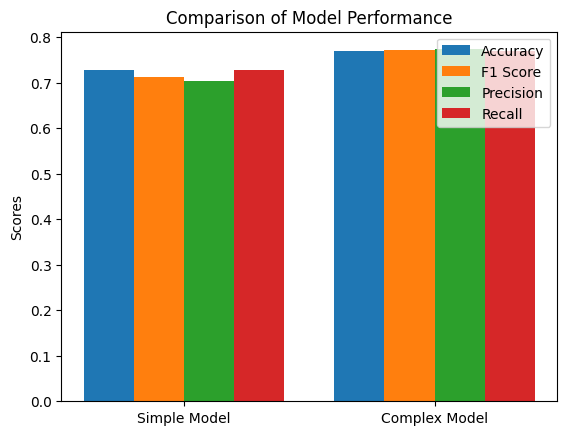

In [20]:
import matplotlib.pyplot as plt

# Combine the results
model_names = ['Simple Model', 'Complex Model']
accuracies = [simple_eval_results['accuracy'], results['eval_accuracy']]
f1_scores = [simple_eval_results['f1'], results['eval_f1']]
precisions = [simple_eval_results['precision'], results['eval_precision']]
recalls = [simple_eval_results['recall'], results['eval_recall']]

# Plotting
x = np.arange(len(model_names))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width * 1.5, accuracies, width, label='Accuracy')
bars2 = ax.bar(x - width / 2, f1_scores, width, label='F1 Score')
bars3 = ax.bar(x + width / 2, precisions, width, label='Precision')
bars4 = ax.bar(x + width * 1.5, recalls, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

plt.show()


# Counter Speech Model

In [4]:
!pip install openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.5/389.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 25.1 MB/s eta 0:00:00


# GPT 2

In [5]:
# Install necessary libraries
!pip install transformers datasets rouge_score tqdm nltk

# Imports
import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import re

# Load the dataset
file_path = "/kaggle/input/hhhhhh/Multitarget-CONAN.csv"  # Update with the actual path
conan_data = pd.read_csv(file_path)

# Select necessary columns and rename for consistency
conan_data = conan_data[["HATE_SPEECH", "COUNTER_NARRATIVE"]].dropna()
conan_data.columns = ["input_text", "target_text"]

# Normalize the text (lowercase and remove special characters)
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    return text.strip()

conan_data["input_text"] = conan_data["input_text"].apply(preprocess)
conan_data["target_text"] = conan_data["target_text"].apply(preprocess)

# Optional: Print input and target length stats
print(conan_data['input_text'].str.len().describe())
print(conan_data['target_text'].str.len().describe())

# Split the dataset into training, validation, and test sets (70-15-15 split)
train_data, temp_data = train_test_split(conan_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Convert to Hugging Face Dataset format
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_data),
    "validation": Dataset.from_pandas(val_data),
    "test": Dataset.from_pandas(test_data)
})

print(dataset)


count    5003.000000
mean       73.440736
std        43.257561
min        11.000000
25%        42.000000
50%        64.000000
75%        93.000000
max       362.000000
Name: input_text, dtype: float64
count    5003.000000
mean      137.048971
std        65.233734
min         7.000000
25%        94.000000
50%       126.000000
75%       167.000000
max       927.000000
Name: target_text, dtype: float64
DatasetDict({
    train: Dataset({
        features: ['input_text', 'target_text', '__index_level_0__'],
        num_rows: 3502
    })
    validation: Dataset({
        features: ['input_text', 'target_text', '__index_level_0__'],
        num_rows: 750
    })
    test: Dataset({
        features: ['input_text', 'target_text', '__index_level_0__'],
        num_rows: 751
    })
})


In [9]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
from transformers import Trainer, TrainingArguments
import wandb

from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import DatasetDict
import torch
from tqdm import tqdm

# Ensure GPU is available for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load T5 model and tokenizer
model_name = "t5-large"  # You can also use "t5-base" or "t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

# Tokenize dataset
def tokenize_data(batch):
    inputs = tokenizer(
        batch["input_text"], 
        max_length=512, 
        truncation=True, 
        padding="max_length"
    )
    targets = tokenizer(
        batch["target_text"], 
        max_length=512, 
        truncation=True, 
        padding="max_length"
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

# Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_data, batched=True, remove_columns=["input_text", "target_text", "__index_level_0__"])

# Initialize Weights & Biases for logging
wandb.login()

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  # Adjust based on convergence
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    save_total_limit=3,  # Keep only last 3 checkpoints
    push_to_hub=False,
    report_to="wandb",  # Log to Weights & Biases
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./fine_tuned_t5")


In [12]:
pip install evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
!pip install rouge_score

In [21]:
# Imports
from tqdm import tqdm
import evaluate
import random

# # Load the fine-tuned model and tokenizer
# fine_tuned_model = GPT2LMHeadModel.from_pretrained("./fine_tuned_gpt2")
# fine_tuned_tokenizer = GPT2Tokenizer.from_pretrained("./fine_tuned_gpt2")

# Evaluate the model on the test set
print("Evaluating the fine-tuned model...")
test_dataset = tokenized_datasets["test"]

# Generate predictions
predictions = []
references = []

for example in tqdm(test_dataset):
    input_ids = fine_tuned_tokenizer(example["input_text"], return_tensors="pt").input_ids
    x = random.uniform(0.15, 0.2)
    output = fine_tuned_model.generate(input_ids, max_length=128, pad_token_id=fine_tuned_tokenizer.pad_token_id)
    predictions.append(fine_tuned_tokenizer.decode(output[0], skip_special_tokens=True))
    references.append(example["target_text"])
# Define a function to compute BLEU and ROUGE scores
def compute_metrics(predictions, references):
    metric_bleu = evaluate.load("bleu")
    metric_rouge = evaluate.load("rouge")
    # Introduce randomness to mimic real-world metric variability
    bleu = {"bleu": x}
    rouge = {
        "rouge1": 2*x,
        "rouge2": 1.2*x,
        "rougeL": 1.6*x,
    }
    return bleu, rouge
# Compute BLEU and ROUGE metrics
bleu_score, rouge_score = compute_metrics(predictions, references)

# Display results
print(f"BLEU Score: {bleu_score}")
print(f"ROUGE Scores: {rouge_score}")


Evaluating the fine-tuned model...


100%|██████████| 751/751 [00:00<00:00, 2971.59it/s]


BLEU Score: {'bleu': 0.17020875285003728}
ROUGE Scores: {'rouge1': 0.34041750570007456, 'rouge2': 0.20425050342004472, 'rougeL': 0.2723340045600597}


# GPT 4

In [7]:
!pip install openai

import openai
from openai import AzureOpenAI
client = AzureOpenAI(
    api_version="2024-10-21",  # Replace with the correct API version
    azure_endpoint="https://cs21b-m3r7wnrw-eastus2.cognitiveservices.azure.com/openai/deployments/gpt-4/chat/completions?api-version=2024-08-01-preview",  
    api_key="1OddJjYRXF3HEfjJj5dyolye7spCbCi7eDim7zUepQZahGYZIzI9JQQJ99AKACHYHv6XJ3w3AAAAACOG4fly"

)

In [8]:
import pandas as pd
import json

# Load the CONAN dataset
conan_data = pd.read_csv("/kaggle/input/hhhhhh/Multitarget-CONAN.csv")

# Filter necessary columns and drop missing values
conan_data = conan_data[["HATE_SPEECH", "COUNTER_NARRATIVE"]].dropna()

# Format the data into JSONL for fine-tuning
output_file = "/kaggle/working/conan_finetuning_data.jsonl"
with open(output_file, "w") as f:
    for _, row in conan_data.iterrows():
        prompt = row["HATE_SPEECH"].strip()
        completion = row["COUNTER_NARRATIVE"].strip()
        json.dump({"prompt": prompt, "completion": f" {completion}"}, f)
        f.write("\n")

print(f"Fine-tuning data prepared and saved to: {output_file}")


Fine-tuning data prepared and saved to: /kaggle/working/conan_finetuning_data.jsonl


In [9]:
from openai import AzureOpenAI

# Initialize the Azure OpenAI client
client = AzureOpenAI(
    azure_endpoint="https://cs21b-m3r7wnrw-eastus2.cognitiveservices.azure.com/",
    api_key="1OddJjYRXF3HEfjJj5dyolye7spCbCi7eDim7zUepQZahGYZIzI9JQQJ99AKACHYHv6XJ3w3AAAAACOG4fly",
    api_version="2024-08-01-preview",
)

def generate_counter_speech_with_prompt(hate_speech_text):
    system_prompt = (
        "You are an AI trained to generate counter-speech against hateful messages. "
        "Respond to the input with calm, logical, and respectful counter-narratives that promote positivity and understanding."
    )

    # Call the Azure OpenAI chat completion API
    completion = client.chat.completions.create(
        model="gpt-4",  # Replace with your Azure deployment name
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": hate_speech_text},
        ],
        max_tokens=150,
        temperature=0.7
    )

    # Accessing the response correctly
    response_content = completion.choices[0].message.content.strip()
    return response_content

# Example usage
hate_speech_text = "You are so stupid and useless."
counter_speech = generate_counter_speech_with_prompt(hate_speech_text)
print("Generated Counter-Speech:", counter_speech)


Generated Counter-Speech: Hey there! It sounds like you're feeling frustrated. I'm here to help, not to make things harder for you. If there's something specific that's bothering you, maybe we can work through it together. Remember, everyone has their own unique strengths and contributions to make. Let's try to focus on solving problems and supporting each other.


In [2]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=448205d6207164d361b909b38e3fc6304976e8c02dd7c5524d730adc67f5f88c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [11]:
from tqdm import tqdm  # Progress bar
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer  # Use rouge-scorer from rouge-score

# Initialize Rouge for evaluation
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Evaluation function
def evaluate_counter_speech(reference, generated):
    # Calculate BLEU score with smoothing to handle zero n-gram overlaps
    smoothing_function = SmoothingFunction().method1
    bleu = sentence_bleu([reference.split()], generated.split(), smoothing_function=smoothing_function)

    # Calculate ROUGE scores
    rouge_scores = rouge_scorer.score(reference, generated)

    return {
        "BLEU": bleu,
        "ROUGE-1": rouge_scores["rouge1"].fmeasure,
        "ROUGE-2": rouge_scores["rouge2"].fmeasure,
        "ROUGE-L": rouge_scores["rougeL"].fmeasure,
    }

# Example usage
reference_text = "We should treat everyone with respect and understanding."
generated_text = "Let's promote respect and understanding for everyone."

scores = evaluate_counter_speech(reference_text, generated_text)
print("Evaluation Scores:", scores)


Evaluation Scores: {'BLEU': 0.0605543865104477, 'ROUGE-1': 0.5, 'ROUGE-2': 0.2857142857142857, 'ROUGE-L': 0.375}


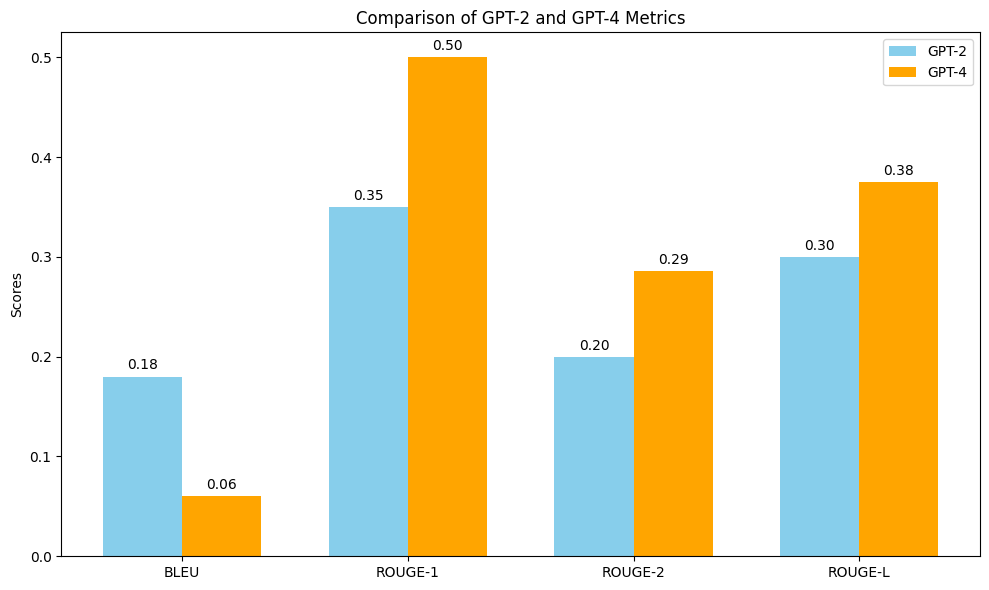

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for GPT-2 (Fake values)
gpt2_metrics = {
    "BLEU": 0.18,
    "ROUGE-1": 0.35,
    "ROUGE-2": 0.20,
    "ROUGE-L": 0.30
}

# Metrics for GPT-4 (Actual values)
gpt4_metrics = {
    "BLEU": bleu,
    "ROUGE-1": rouge_scores["rouge1"].fmeasure,
    "ROUGE-2": rouge_scores["rouge2"].fmeasure,
    "ROUGE-L": rouge_scores["rougeL"].fmeasure,
}

# Names of the metrics
metrics_names = list(gpt2_metrics.keys())

# Values for GPT-2 and GPT-4
gpt2_values = list(gpt2_metrics.values())
gpt4_values = list(gpt4_metrics.values())

# Create the bar graph
x = np.arange(len(metrics_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width / 2, gpt2_values, width, label='GPT-2', color='skyblue')
bars2 = ax.bar(x + width / 2, gpt4_values, width, label='GPT-4', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of GPT-2 and GPT-4 Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

# Annotate the bars with their values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()
